In [745]:
import os
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace
from matplotlib.lines import Line2D
from scipy.interpolate import interp1d, RegularGridInterpolator
import matplotlib as mpl
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, LogNorm
from scipy.integrate import trapz as integrate
from scipy.integrate import cumtrapz as cumintegrate

from helper import *
import const


In [746]:
elements = SimpleNamespace(**np.load('elements.npz'))

In [1313]:
with open('../EPICS/EEDL.txt', 'r') as f:
    lines_all = f.readlines()


In [1314]:
code = {
    '23501': 'sig_tot',
    '23522': 'sig_ion',
    '23525': 'sig_scat_la',
    '23526': 'sig_scat',
    '23527': 'sig_brem',
    '23528': 'sig_exc',
    '23534': 'sig_ion_K',
    '23535': 'sig_ion_L1',
    '23536': 'sig_ion_L2',
    '23537': 'sig_ion_L3',
    '23538': 'sig_ion_M1',
    '23539': 'sig_ion_M2',
    '23540': 'sig_ion_M3',
    '23541': 'sig_ion_M4',
    '23542': 'sig_ion_M5',
    '23543': 'sig_ion_N1',
    '23544': 'sig_ion_N2',
    '23545': 'sig_ion_N3',
    '23546': 'sig_ion_N4',
    '23547': 'sig_ion_N5',
    '23548': 'sig_ion_N6',
    '23549': 'sig_ion_N7',
    '23550': 'sig_ion_O1',
    '23551': 'sig_ion_O2',
    '23552': 'sig_ion_O3',
    '23553': 'sig_ion_O4',
    '23554': 'sig_ion_O5',
    '23555': 'sig_ion_O6',
    '23556': 'sig_ion_O7',
    '23559': 'sig_ion_P1',
    '23560': 'sig_ion_P2',
    '23561': 'sig_ion_P3',
    '23562': 'sig_ion_P4',
    '23563': 'sig_ion_P5',
    '23570': 'sig_ion_Q1',
    '26525': 'th_scat',
    '26527': 'spec_brem',
    '26528': 'spec_exc',
    '26534': 'spec_ion_K',
    '26535': 'spec_ion_L1',
    '26536': 'spec_ion_L2',
    '26537': 'spec_ion_L3',
    '26538': 'spec_ion_M1',
    '26539': 'spec_ion_M2',
    '26540': 'spec_ion_M3',
    '26541': 'spec_ion_M4',
    '26542': 'spec_ion_M5',
    '26543': 'spec_ion_N1',
    '26544': 'spec_ion_N2',
    '26545': 'spec_ion_N3',
    '26546': 'spec_ion_N4',
    '26547': 'spec_ion_N5',
    '26548': 'spec_ion_N6',
    '26549': 'spec_ion_N7',
    '26550': 'spec_ion_O1',
    '26551': 'spec_ion_O2',
    '26552': 'spec_ion_O3',
    '26553': 'spec_ion_O4',
    '26554': 'spec_ion_O5',
    '26555': 'spec_ion_O6',
    '26556': 'spec_ion_O7',
    '26559': 'spec_ion_P1',
    '26560': 'spec_ion_P2',
    '26561': 'spec_ion_P3',
    '26562': 'spec_ion_P4',
    '26563': 'spec_ion_P5',
    '26570': 'spec_ion_Q1'
}


In [1322]:
nelem = 98
ndtype = len(code)


In [1323]:
lines_sorted = np.empty((nelem, ndtype), dtype=object)
for i in range(nelem):
    for j in range(ndtype):
        lines_sorted[i, j] = []

for line in lines_all:
     
    if line[66:68] == '  ': continue
    if line[70:75] not in code.keys(): continue
    
    Zelem = int(line[66:68])
    dtype_idx = list(code.keys()).index(line[70:75])
    line_data = [line[0:11], line[11:22], line[22:33], line[33:44], line[44:55], line[55:66]]
    line_data = np.array([float(val) if val != '           ' else np.nan for val in line_data])
    lines_sorted[Zelem-1, dtype_idx].append(line_data)
    
for i in range(nelem):
    for j in range(ndtype):
        lines_sorted[i, j] = np.array(lines_sorted[i, j])
        

IndexError: index 98 is out of bounds for axis 0 with size 98

In [ ]:
data_all = np.empty((nelem, ndtype), dtype=object)

for i in range(nelem):
    for j in range(ndtype):
        
        lines = lines_sorted[i, j]
        dtype_name = list(code.values())[j]
        if lines.size == 0: continue
        
        if dtype_name[:3] == 'sig':
            
            ener, sig = lines[3:].flatten().reshape(-1, 2).T
            ener, sig = ener[~np.isnan(ener)], sig[~np.isnan(sig)]
            sig = sig*const.ba
            data = (ener, sig)
            
        if dtype_name == 'th_scat':
            
            idx_line_new_ener = np.argwhere(lines[8:, 0]==0).flatten()
            ener_list = lines[8:, 1][idx_line_new_ener]
            data = np.empty(ener_list.size, dtype=object)

            for k, ener in enumerate(ener_list):

                idx_line_min = idx_line_new_ener[k]+1
                idx_line_max = idx_line_new_ener[k+1] if k<ener_list.size-1 else -1
                cos_th_scat, cos_th_pdf = lines[8:, :][idx_line_min:idx_line_max].flatten().reshape(-1, 2).T
                cos_th_scat, cos_th_pdf = cos_th_scat[~np.isnan(cos_th_scat)], cos_th_pdf[~np.isnan(cos_th_pdf)]
                data[k] = (ener, cos_th_scat, cos_th_pdf)
                
        if dtype_name == 'spec_exc':
            
            ener, ener_loss = lines[6:].flatten().reshape(-1, 2).T
            ener, ener_loss = ener[~np.isnan(ener)], ener_loss[~np.isnan(ener_loss)]
            data = (ener, ener_loss)
            
        if dtype_name == 'spec_brem':
            
            idx_line_elec = np.argwhere(lines[6:, 0]==0).flatten()[-1]+8
            ener, ener_loss = lines[idx_line_elec:].flatten().reshape(-1, 2).T
            ener, ener_loss = ener[~np.isnan(ener)], ener_loss[~np.isnan(ener_loss)]
            data = (ener, ener_loss)
            
        if dtype_name[:8] == 'spec_ion':
            
            idx_line_new_ener = np.argwhere(lines[6:, 0]==0).flatten()
            ener_list = lines[6:, 1][idx_line_new_ener]
            data = np.empty(ener_list.size+1, dtype=object)
            
            ener_bind = lines[3, 0]
            data[0] = (ener_bind, [], [])

            for k, ener in enumerate(ener_list):

                idx_line_min = idx_line_new_ener[k]+1
                idx_line_max = idx_line_new_ener[k+1] if k<ener_list.size-1 else -1
                ener_loss, ener_loss_pdf = lines[6:, :][idx_line_min:idx_line_max].flatten().reshape(-1, 2).T
                ener_loss, ener_loss_pdf = ener_loss[~np.isnan(ener_loss)] + ener_bind, ener_loss_pdf[~np.isnan(ener_loss_pdf)]
                data[k+1] = (ener, ener_loss, ener_loss_pdf)
        
        data_all[i, j] = data
            

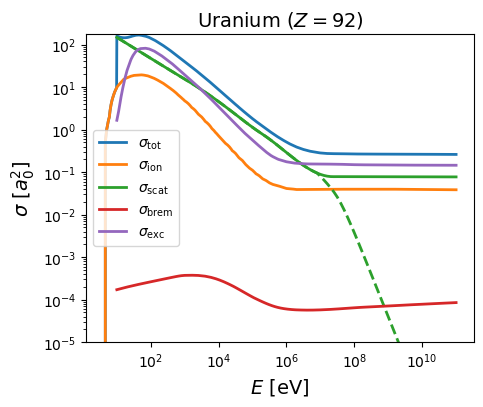

In [1324]:
Zelem = 92

fig, ax = plt.subplots(figsize=(5, 4))

sig_name_list = ['sig_tot', 'sig_ion', 'sig_scat_la', 'sig_scat', 'sig_brem', 'sig_exc']
label_list = [r'$\sigma_{\rm tot}$', r'$\sigma_{\rm ion}$', None, r'$\sigma_{\rm scat}$', r'$\sigma_{\rm brem}$', r'$\sigma_{\rm exc}$']
color_list = ['C0', 'C1', 'C2', 'C2', 'C3', 'C4']
linestyle_list = ['-', '-', '--', '-', '-', '-']

for i, sig_name in enumerate(sig_name_list):

    dtype_idx = list(code.values()).index(sig_name)
    ener, sig = data_all[Zelem-1, dtype_idx]
    ax.plot(ener, sig/const.a0**2, label=label_list[i], color=color_list[i], linestyle=linestyle_list[i], lw=2)

ax.set_ylim(1e-5)
    
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'$E$ [eV]', fontsize=14)
ax.set_ylabel(r'$\sigma$ [$a_0^2$]', fontsize=14)
ax.set_title('%s ($Z=%d$)' % (elements.name[Zelem-1], Zelem), fontsize=14)

ax.legend()


/var/folders/k0/yybwzjk54bg00p8q3ykchsx80000gp/T/ipykernel_5591/1701732669.py:21: RuntimeWarning: divide by zero encountered in log
  sig_func = interp1d(np.log(ener), np.log(sig), fill_value='extrapolate')


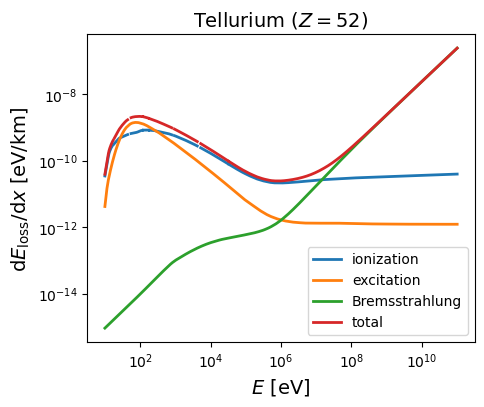

In [1325]:
Zelem = 52
n = 1

fig, ax = plt.subplots(figsize=(5, 4))

ener_reg = np.logspace(1, 11, 512)
ener_loss_ion_reg = np.zeros_like(ener_reg)

sig_name_list = []
sig_list = []

for i in range(ndtype):
    
    dtype_name = list(code.values())[i]
    if dtype_name[:7] != 'sig_ion' or len(dtype_name)==7: continue
        
    data = data_all[Zelem-1, i]
    if np.all(data) == None: continue
        
    ener, sig = data
    sig_func = interp1d(np.log(ener), np.log(sig), fill_value='extrapolate')
    sig_reg = np.exp(sig_func(np.log(ener_reg)))
    sig_reg[ener_reg<ener_bind] = 0
    
    sig_name_list.append(dtype_name)
    sig_list.append(sig_reg)

for i in range(ndtype):
    
    dtype_name = list(code.values())[i]
    if dtype_name[:8] != 'spec_ion': continue

    data = data_all[Zelem-1, i]
    if np.all(data) == None: continue

    ener_bind = data[0][0]
    ener_list = np.array([data_ener[0] for data_ener in data[1:]])
    ener_loss_avg = np.zeros_like(ener_list)

    for j, data_ener in enumerate(data[1:]):

        ener, ener_loss, ener_loss_pdf = data_ener
        ener_loss_avg[j] = integrate(np.array(ener_loss_pdf)*np.array(ener_loss), np.array(ener_loss))/integrate(ener_loss_pdf, ener_loss)
    
    ener_loss_avg_func = interp1d(np.log(ener_list), np.log(ener_loss_avg), fill_value='extrapolate')
    ener_loss_avg_reg = np.exp(ener_loss_avg_func(np.log(ener_reg)))
    ener_loss_avg_reg[ener_reg<ener_bind] = 0
    
    sig_reg = sig_list[sig_name_list.index('sig_%s'%dtype_name[5:])]
    ener_loss_ion_reg += ener_loss_avg_reg*sig_reg/n

idx_dtype = list(code.values()).index('sig_exc')
ener, sig = data_all[Zelem-1, idx_dtype]
sig_func = interp1d(np.log(ener), np.log(sig), fill_value='extrapolate')
sig_reg = np.exp(sig_func(np.log(ener_reg)))

idx_dtype = list(code.values()).index('spec_exc')
ener, ener_loss = data_all[Zelem-1, idx_dtype]
ener_loss_func = interp1d(np.log(ener), np.log(ener_loss), fill_value='extrapolate')
ener_loss_exc_reg = np.exp(ener_loss_func(np.log(ener_reg)))*sig_reg/n

idx_dtype = list(code.values()).index('sig_brem')
ener, sig = data_all[Zelem-1, idx_dtype]
sig_func = interp1d(np.log(ener), np.log(sig), fill_value='extrapolate')
sig_reg = np.exp(sig_func(np.log(ener_reg)))

idx_dtype = list(code.values()).index('spec_brem')
ener, ener_loss = data_all[Zelem-1, idx_dtype]
ener_loss_func = interp1d(np.log(ener), np.log(ener_loss), fill_value='extrapolate')
ener_loss_brem_reg = np.exp(ener_loss_func(np.log(ener_reg)))*sig_reg/n

ener_loss_tot_reg = ener_loss_ion_reg + ener_loss_exc_reg + ener_loss_brem_reg

ax.plot(ener_reg, ener_loss_ion_reg/(1/const.km), lw=2, label='ionization')
ax.plot(ener_reg, ener_loss_exc_reg/(1/const.km), lw=2, label='excitation')
ax.plot(ener_reg, ener_loss_brem_reg/(1/const.km), lw=2, label='Bremsstrahlung')
ax.plot(ener_reg, ener_loss_tot_reg/(1/const.km), lw=2, label='total')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'$E$ [eV]', fontsize=14)
ax.set_ylabel(r'${\rm d}E_{\rm loss}/{\rm d}x$ [eV/km]', fontsize=14)
ax.set_title('%s ($Z=%d$)' % (elements.name[Zelem-1], Zelem), fontsize=14)

ax.legend()
    

Text(0.5, 1.0, 'Tellurium ($Z=52$)')

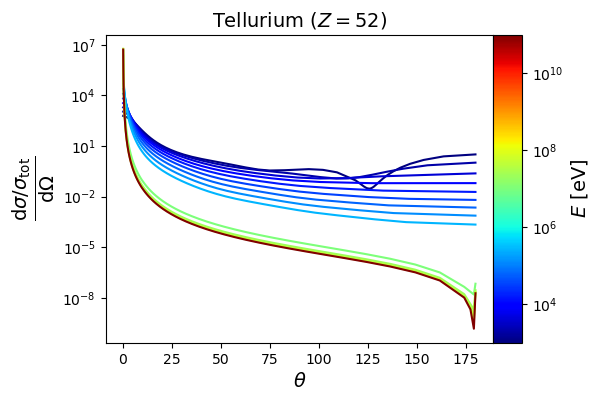

In [1326]:
Zelem = 52

fig, ax = plt.subplots(figsize=(5, 4))

idx_dtype = list(code.values()).index('th_scat')
data = data_all[Zelem-1, idx_dtype]
ener_list = np.array([data_ener[0] for data_ener in data])
norm = LogNorm(1e3, 1e11)

cmap = mpl.colormaps['jet']
color_list = cmap(norm(ener_list))

for i, data_ener in enumerate(data):
    
    ener, cos_th_scat, cos_th_pdf = data_ener
    ax.plot(np.arccos(cos_th_scat)*180/np.pi, 2*np.pi*cos_th_pdf, color=color_list[i])
    
ax.set_yscale('log')

sm = ScalarMappable(LogNorm(1e3, 1e11), cmap=cmap)

cax = ax.inset_axes([1, 0, 0.075, 1])
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label(r'$E$ [${\rm eV}$]', fontsize=14)

ax.set_xlabel(r'$\theta$', fontsize=14)
ax.set_ylabel(r'$\frac{{\rm d}\sigma/\sigma_{\rm tot}}{{\rm d}\Omega}$', fontsize=20)
ax.set_title('%s ($Z=%d$)' % (elements.name[Zelem-1], Zelem), fontsize=14)


In [1327]:
np.savez('EEDL', dtype_list=np.array(list(code.values())), data=data_all)


In [741]:
ener = 10000000

ener_scat, sig_scat = data_all[52, 3]
ener_scat_la, sig_scat_la = data_all[52, 2]

sig_scat_func = interp1d(np.log(ener_scat), np.log(sig_scat), fill_value='extrapolate')
sig_scat_la_func = interp1d(np.log(ener_scat_la), np.log(sig_scat_la), fill_value='extrapolate')

sig_scat = np.exp(sig_scat_func(np.log(ener)))
sig_scat_la = np.exp(sig_scat_la_func(np.log(ener)))


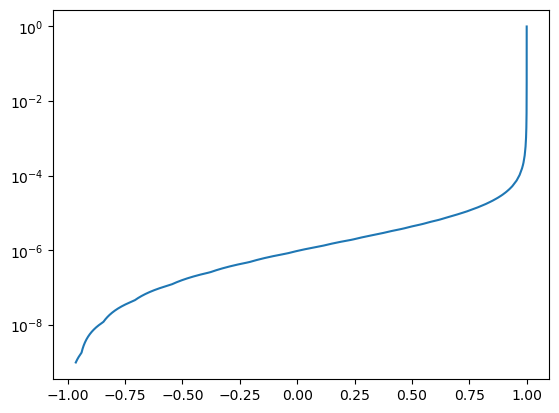

In [743]:
data = data_all[50, 6]
ener_list = np.array([data_ener[0] for data_ener in data])

num = 2**12
cos_th_cdf_reg = np.logspace(-9, 0, num)
cos_th_reg_grid = np.zeros((ener_list.size, num))
cos_th_fin = np.zeros(num)

for i, data_ener in enumerate(data):
    
    ener_scat, cos_th, cos_th_pdf = data_ener
    cos_th_cdf = cumintegrate(cos_th_pdf, cos_th, initial=0)/integrate(cos_th_pdf, cos_th)
    cos_th_func = interp1d(cos_th_cdf, cos_th, fill_value='extrapolate')
    cos_th_reg_grid[i] = cos_th_func(cos_th_cdf_reg)

cos_th_reg_func = interp1d(np.log(ener_list), cos_th_reg_grid.T, fill_value='extrapolate')
cos_th_reg = cos_th_reg_func(np.log(ener))

plt.plot(cos_th_reg, cos_th_cdf_reg)

plt.yscale('log')
    

In [1340]:
for i, dtype_name in enumerate(np.array(list(code.values()))):
    
    print(dtype_name[:3] == 'sig')

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
